# DATA 200 Final Project: Contraception

*Team Members: Isabel Serrano, Edie Espejo, and Asem Berkalieva*

This notebook contains all of the code for conducting our final project. It is organized into the following sections:

1. Exploratory Data Analysis (EDA)
2. Feature Engineering and Data Cleaning
3. Modeling (Logistic Regression and Random Forests)
    - 3a. Contraception use by no use, short term, long term 
    - 3b. Contraception use by yes vs. no  
    - 3c. Contraception use by short term vs. long term (for those on contraception)
4. Assessing Precision and Recall

In [1]:
# import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re

In [2]:
# read in raw dataset
contra = pd.read_csv('../../1-data/contraceptive_for_students.csv')
this_dic = {1:0, 3:1, 2:2}
contra['contraceptive'] = contra['contraceptive'].map(this_dic)

In [3]:
# explore
contra.head(5)

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,0
1,45,1,3,10,1,1,3,4,0,0
2,43,2,3,7,1,1,3,4,0,0
3,42,3,2,9,1,1,3,3,0,0
4,36,3,3,8,1,1,3,2,0,0


In [4]:
# split into train and test
contra_train, contra_test = train_test_split(contra, test_size=0.25, random_state=100)

## 1. Exploratory Data Analysis

## 2. Feature Engineering and Data Cleaning

We have written a wrapper function that preprocesses the raw data and outputs a train and test dataset that can be fed into the modeling code. 

We will use the following function without our preprocessing function:

In [5]:
# the following function cleans the lower bound and upper bound of the intervals into their own columns.
def cleanIntervals(age_intervals):
    '''
    Input:
        age_intervals: Array of intervals
    Output:
        lows: An array of lower bounds
        highs: An array of upper bounds
    '''
    
    lows  = []
    highs = []
    
    for ix in range(len(age_intervals)):
        lo_hi = [re.sub('\(|\]', '', k) for k in age_intervals[ix].split(',')]
        lows.append(lo_hi[0])
        highs.append(lo_hi[1])
        
    return(np.array(lows),
           np.array(highs))

The following is the complete processing function that takes in the raw contraception dataset and output the train and test data:

In [6]:
def preprocess(data):
    
    # 1. define Kids Per Married Year:
    
    ### 1a. drop those under 20
    data = data[data.wife_age > 20]
    data = data.reset_index(drop=True)
    
    ### set age intervals to define median age married
    age_intervals = pd.IntervalIndex.from_tuples([(20, 24), (24, 29), (29, 34), (34,39), (39,44), (44, 49)])
    age_interval_df = pd.DataFrame(age_intervals)
    age_interval_df['median_marriage_age'] = [19.6, 18.1, 17.6, 16.8, 16.4, 16.5]
    age_interval_df = age_interval_df.rename({0:'age_bin'}, axis=1)
    age_interval_df['age_bin'] = age_interval_df['age_bin'].astype(str)
    age_interval_df['age_bin_low'], age_interval_df['age_bin_high'] = cleanIntervals(age_interval_df.age_bin)
    data['age_bin'] = pd.cut(data.wife_age, bins=age_intervals)

    ### fill the NA's
    data['age_bin'] = data['age_bin'].cat.add_categories('None')
    data['age_bin'] = data['age_bin'].fillna('None')
    data['age_bin'] = data['age_bin'].astype(str)
    
    data['age_bin_low'], data['age_bin_high'] = cleanIntervals(data.age_bin)
    data = data.merge(age_interval_df)
    
    ### create est_years_married: wife's age minus median marriage age for age group
    data['est_years_married'] = data['wife_age'] - data['median_marriage_age']
    
    ### create kids_per_year: amount of kids divided by number of est years married
    data['kids_per_year'] = data['num_child'] / data['est_years_married']
    
    ### drop unnecessary age_bin feature
    data.drop(['age_bin'], axis=1, inplace=True)
    
    # 2. Education gap
    data['education_gap'] = data['husband_education'] - data['wife_education']
    gap_intervals = [-3, 0, 1, 4]
    data['education_gap_categorical'] = pd.cut(data.education_gap, bins=gap_intervals, labels=[-1, 0, 1], right=False)
    
    # 3. Contraceptive Use
    this_dic = {0:0, 1:1, 2:1}
    data['contraceptive_use'] = data['contraceptive'].map(this_dic)
    
    # 4. Adjusted Standard of Living
    
    ### combine middle-low and middle-high into single category
    this_dic = {1: 1, 2:2, 3:2, 4:3}
    data['standard_living'] = data['standard_living'].map(this_dic)
    
    # 5. Adjusted Education Level
    
    ### separate wives' education level into 0 for not having completed primary school and 1 for completing primary school
    this_dic = {1:0, 2:0, 3:1, 4:1}
    data['wife_education'] = data['wife_education'].map(this_dic)
    
    # 6. One-hot Encoding Categorical Variables
    data = pd.get_dummies(data,
                        columns=['wife_education', 'husband_education', 'wife_religion',
                                 'wife_work', 'husband_occupation', 'standard_living',
                                 'media_exposure', 'education_gap_categorical'],
                        drop_first=True)
    
    # 7. Scaling Continuous Variables
    continuous_vars = ['wife_age', 'num_child', 'kids_per_year', 'est_years_married']
    standardized_vars = pd.DataFrame(StandardScaler().fit_transform(data[continuous_vars]), columns=continuous_vars)
    
    ### drop original, non-scaled variables
    data.drop(continuous_vars, axis=1, inplace=True)
    data = data.join(standardized_vars)
    
    # 8. return cleaned dataset
    return data

In [7]:
# apply function to the two datasets
contra_train = preprocess(contra_train)
contra_test = preprocess(contra_test)

In [8]:
# examine outputs
[contra.shape, contra_train.shape, contra_test.shape]

[(1473, 10), (1056, 24), (353, 24)]

## 3. Modeling

We will predict and compare three outcomes of interest:

- Contraceptive method of (1) no use, (2) short term, (3) long term
- Contraceptive method of (1) no use vs. (2) use?
- Contraceptive method of (1) short-term vs. (2) long-term for those on contraception

Which of the three above has a better prediction accuracy? What are the pros and cons of each? 

Additionally, by running logistic regression and Random Forests on each of the above, we hope to assess which model performs better and why.

### 3a. Predicting Contraceptive: No Use, Short Term, Long Term
#### i. Feature Selection and Data Preparation
We will start by running our model with all existing features in the dataset to evaluate initial performance.

In [51]:
# training data
# remove the first 2 because they are the response
# remove age_bin because they were used for another variable
# remove education_gap because it was coded into a categorical variable
X_train = contra_train.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                             'education_gap', 'wife_age', 'num_child'], axis = 1)
Y_train = contra_train['contraceptive']

# test data
X_test = contra_test.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                           'education_gap', 'wife_age', 'num_child'], axis = 1)
Y_test = contra_test['contraceptive']

#### ii. Multinomial Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

# fit multinomial model
multinomial_logit = LogisticRegression(multi_class='multinomial', solver='newton-cg')
multinomial_logit.fit(X = X_train, y = Y_train)

# obtain accuracies (train and CV)
train_accuracy_lr = multinomial_logit.score(X = X_train, y = Y_train)
test_accuracy_lr  = multinomial_logit.score(X = X_test, y = Y_test)

# print accuracy
[train_accuracy_lr, test_accuracy_lr]

[0.5606060606060606, 0.46175637393767704]

In [11]:
from sklearn.linear_model import LogisticRegressionCV

# fit multinomial CV model
multinomial_logit_cv = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='newton-cg')
multinomial_logit_cv.fit(X = X_train, y = Y_train)

# obtain CV accuracies
train_accuracy_cv = multinomial_logit_cv.score(X = X_train, y = Y_train)
test_accuracy_cv  = multinomial_logit_cv.score(X = X_test, y = Y_test)

# print
[train_accuracy_cv, test_accuracy_cv]

[0.5643939393939394, 0.45609065155807366]

#### iv. Visualize Feature Selection vs. CV Error
To select features, we began with including all features in the model and removing, one by one, those that decreased training error. We have written a function that evaluates this for the first round (first feature removal) and subsequently, we plot this to more easily visualize the effect of feature removal.

In [12]:
# modified df
contra_df = contra_train.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', \
                               'age_bin_high', 'education_gap'], axis = 1)

# features we will remove one by one
quantitative_features = ['median_marriage_age', 'wife_education_1', 'wife_religion_1', \
                         'wife_work_1', 'media_exposure_1', 'wife_age', 'num_child', \
                         'kids_per_year', 'est_years_married']

# to track accuracy for features
accuracy_train = {}
accuracy_cv_train = {}

# loop through feature removal
for i in range(len(quantitative_features)):

    # The name we are giving to the ith model
    name = quantitative_features[i]

    # subset dataframe
    X_train = contra_df.drop(quantitative_features[i], axis = 1)
    Y_train = contra_train['contraceptive']

    # initialize models
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    model_cv = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='newton-cg')

    # fit models
    model.fit(X = X_train, y = Y_train)
    model_cv.fit(X = X_train, y = Y_train)
    train_model = model.score(X = X_train, y = Y_train)
    train_model_cv = model_cv.score(X = X_train, y = Y_train)

    # Saving the ith model
    accuracy_train[name] = train_model
    accuracy_cv_train[name] = train_model_cv

In [13]:
def visualize_errors(accuracy_train, accuracy_cv):
    
    # prepare train df for plotting
    accuracy_train_df = pd.DataFrame(accuracy_train.items(), columns = ['feature','accuracy'])
    accuracy_train_df['type'] = 'train'

    # prepare cv df for plotting
    accuracy_cv_df = pd.DataFrame(accuracy_cv.items(), columns = ['feature','accuracy'])
    accuracy_cv_df['type'] = 'cv'

    # combine datasets
    accuracy_df = pd.concat([accuracy_train_df, accuracy_cv_df])

    # generate plot
    plt.figure(figsize=(10,8))
    ax = sns.barplot(x = 'feature', y = 'accuracy', hue = 'type', data = accuracy_df,
                    palette=['#DF6589', '#FFC3AF'])
    ax.set(xlabel='Feature',
           ylabel='Accuracy');
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    
    # return plot
    return ax

[Text(0.5, 1.0, 'Multinomial Logistic Regression Model Accuracy Removing Each Feature')]

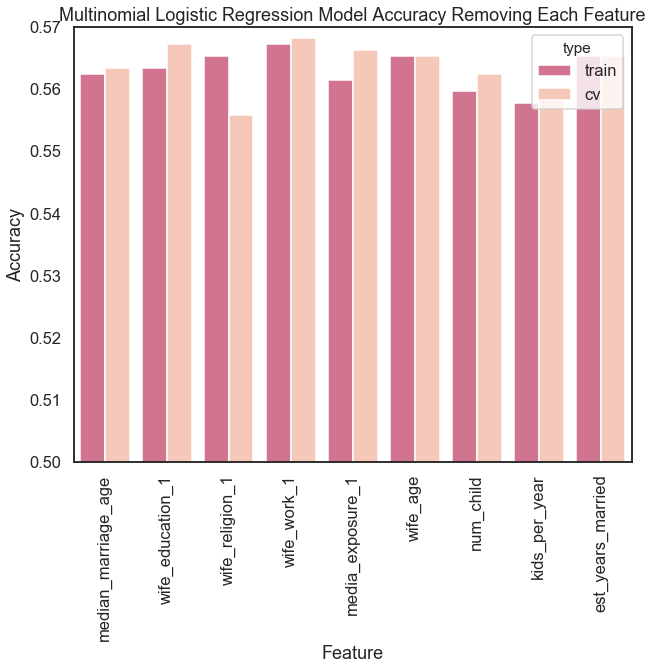

In [14]:
# visualize
ax = visualize_errors(accuracy_train, accuracy_cv_train)
plt.ylim(0.5, 0.57)
ax.set(title = 'Multinomial Logistic Regression Model Accuracy Removing Each Feature')

#### iii. Random Forests

To fit a Random Forests model to the data, we will tune the number of trees using cross-validation, while allowing the Random Forests algorithm to tune the remaining features through its use of bagging. We visualize the training and cross-validated accuracies for a range of number trees to (1) confirm overfitting occurs when fitting on a single training set and (2) select the number of trees we will use.

In [15]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# to track accuracy for features
accuracy_train_rf = {}
accuracy_cv_rf = {}
n_trees = range(5, 30, 5)

# cross validate for n trees
for i in n_trees:
    
    # fit model
    random_forest = ensemble.RandomForestClassifier(n_estimators = i)
    random_forest.fit(X = X_train, y = Y_train)
    
    # obtain accuracy
    accuracy_train_rf[i] = random_forest.score(X = X_train, y = Y_train)
    accuracy_cv_rf[i] = cross_val_score(random_forest, X_train, Y_train, cv = 5).mean()

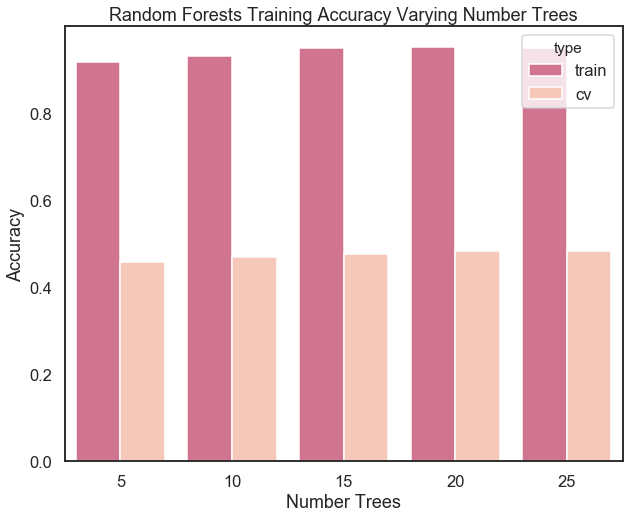

In [16]:
# prepare train df for plotting
accuracy_train_df = pd.DataFrame(accuracy_train_rf.items(), columns = ['n_tree','accuracy'])
accuracy_train_df['type'] = 'train'
accuracy_train_df

# prepare cv df for plotting
accuracy_cv_df = pd.DataFrame(accuracy_cv_rf.items(), columns = ['n_tree','accuracy'])
accuracy_cv_df['type'] = 'cv'

# combine datasets
accuracy_df = pd.concat([accuracy_train_df, accuracy_cv_df])

# generate plot
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'n_tree', y = 'accuracy', hue = 'type', data = accuracy_df,
                palette=['#DF6589', '#FFC3AF'])
ax.set(xlabel='Number Trees',
       ylabel='Accuracy',
       title = 'Random Forests Training Accuracy Varying Number Trees');

In [21]:
# fit final model with n tree selected
random_forest = ensemble.RandomForestClassifier(n_estimators=25)
random_forest.fit(X = X_train, y = Y_train)

# obtain accuracies
train_accuracy_rf = random_forest.score(X = X_train, y = Y_train)
test_accuracy_rf = random_forest.score(X = X_test, y = Y_test)

# print
[train_accuracy_rf, test_accuracy_rf]

[0.9526515151515151, 0.5127478753541076]

### 3b. Predicting Binary Contraceptive: No vs. Yes
#### i. Feature Selection and Data Preparation

In [22]:
# training data
X_train_binary = contra_train.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                    'education_gap', 'wife_age'], axis = 1)
Y_train_binary = contra_train['contraceptive_use']

# test data
X_test_binary = contra_test.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                  'education_gap', 'wife_age'], axis = 1)
Y_test_binary = contra_test['contraceptive_use']

#### ii. Binary Logistic Regression

In [23]:
# fit binomial logistic regression model
binary_logit = LogisticRegression(solver = 'newton-cg')
binary_logit.fit(X = X_train_binary, y = Y_train_binary)

# obtain accuracies
train_accuracy_lr_binary = binary_logit.score(X = X_train_binary, y = Y_train_binary)
test_accuracy_lr_binary  = binary_logit.score(X = X_test_binary, y = Y_test_binary)

# print
[train_accuracy_lr_binary, test_accuracy_lr_binary]

[0.7111742424242424, 0.6770538243626062]

In [24]:
# fit CV binomial model
binary_logit_cv = LogisticRegressionCV(cv = 10, solver = 'newton-cg')
binary_logit_cv.fit(X = X_train_binary, y = Y_train_binary)

# obtain accuracies
train_accuracy_cv_binary = binary_logit_cv.score(X = X_train_binary, y = Y_train_binary)
test_accuracy_cv_binary  = binary_logit_cv.score(X = X_test_binary, y = Y_test_binary)

# print
[train_accuracy_cv_binary, test_accuracy_cv_binary]

[0.7007575757575758, 0.6685552407932012]

#### iii. Visualize Feature Selection vs. CV Error

In [27]:
# modified df
contra_df = contra_train.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', \
                               'age_bin_high', 'education_gap'], axis = 1)

# features we will drop one by one
quantitative_features = ['median_marriage_age', 'wife_education_1', 'wife_religion_1', \
                         'wife_work_1', 'media_exposure_1', 'wife_age', 'num_child', \
                         'kids_per_year', 'est_years_married']

# to track accuracy for features
accuracy_train = {}
accuracy_cv_train = {}

# loop through feature removal
for i in range(len(quantitative_features)):

    # The name we are giving to the ith model
    name = quantitative_features[i]

    # subset dataframe
    X_train = contra_df.drop(quantitative_features[i], axis = 1)
    Y_train = contra_train['contraceptive_use']

    # initialize models
    model = LogisticRegression(solver = 'newton-cg')
    model_cv = LogisticRegressionCV(cv=10, solver='newton-cg')

    # fit models
    model.fit(X = X_train, y = Y_train)
    model_cv.fit(X = X_train, y = Y_train)
    train_model = model.score(X = X_train, y = Y_train)
    train_model_cv = model_cv.score(X = X_train, y = Y_train)

    # Saving the ith model
    accuracy_train[name] = train_model
    accuracy_cv_train[name] = train_model_cv

[Text(0.5, 1.0, 'Binary Logistic Regression Model Accuracy Removing Each Feature: Use vs. No Use')]

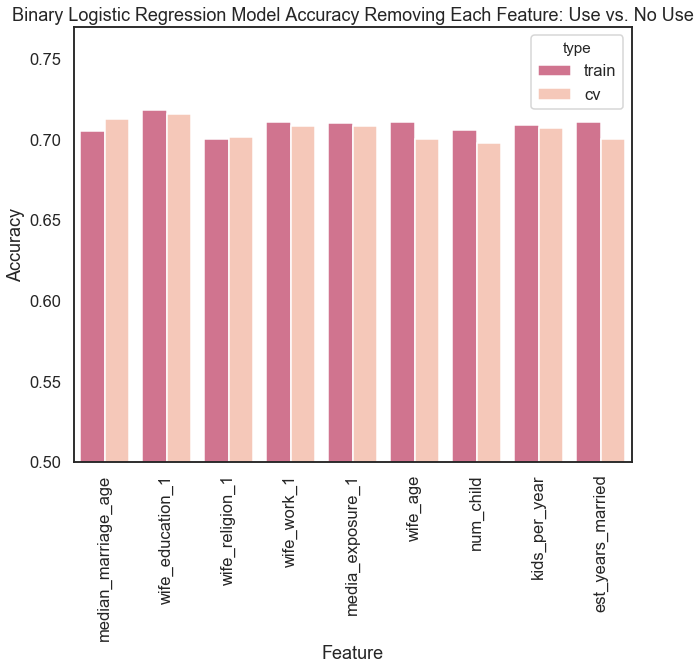

In [33]:
# visualize
ax = visualize_errors(accuracy_train, accuracy_cv_train)
plt.ylim(0.5, 0.77)
ax.set(title = 'Binary Logistic Regression Model Accuracy Removing Each Feature: Use vs. No Use')

#### iii. Random Forests

In [36]:
# to track accuracy for features
accuracy_train_rf = {}
accuracy_cv_rf = {}
n_trees = range(5, 30, 5)

# cross validate for n trees
for i in n_trees:
    
    # fit model
    random_forest = ensemble.RandomForestClassifier(n_estimators = i)
    random_forest.fit(X = X_train_binary, y = Y_train_binary)
    
    # obtain accuracy
    accuracy_train_rf[i] = random_forest.score(X = X_train_binary, y = Y_train_binary)
    accuracy_cv_rf[i] = cross_val_score(random_forest, X_train_binary, Y_train_binary, cv = 5).mean()

{5: 0.6544818878995755,
 10: 0.6591311642246096,
 15: 0.6639021814573992,
 20: 0.6572308308103711,
 25: 0.6647912860932623}

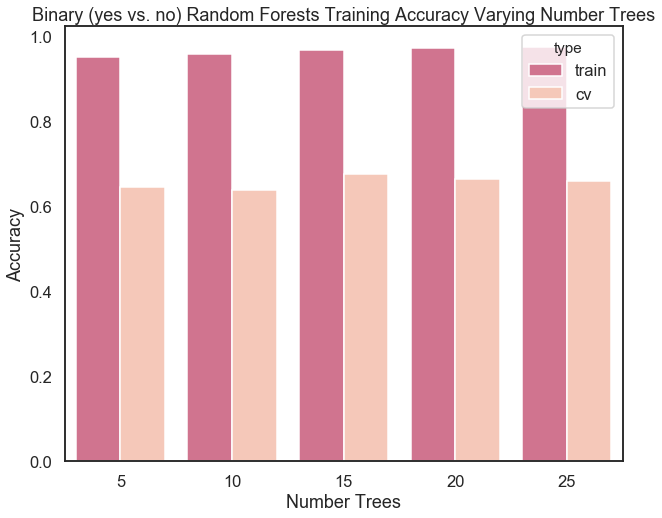

In [35]:
# prepare train df for plotting
accuracy_train_df = pd.DataFrame(accuracy_train_rf.items(), columns = ['n_tree','accuracy'])
accuracy_train_df['type'] = 'train'
accuracy_train_df

# prepare cv df for plotting
accuracy_cv_df = pd.DataFrame(accuracy_cv_rf.items(), columns = ['n_tree','accuracy'])
accuracy_cv_df['type'] = 'cv'

# combine datasets
accuracy_df = pd.concat([accuracy_train_df, accuracy_cv_df])

# generate plot
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'n_tree', y = 'accuracy', hue = 'type', data = accuracy_df,
                palette=['#DF6589', '#FFC3AF'])
ax.set(xlabel='Number Trees',
       ylabel='Accuracy',
       title = 'Binary (yes vs. no) Random Forests Training Accuracy Varying Number Trees');

In [37]:
# fit model
binary_random_forest = ensemble.RandomForestClassifier(n_estimators = 25)
binary_random_forest.fit(X = X_train_binary, y = Y_train_binary)

# obtain accuracies
train_accuracy_rf_binary = binary_random_forest.score(X = X_train_binary, y = Y_train_binary)
test_accuracy_rf_binary  = binary_random_forest.score(X = X_test_binary, y = Y_test_binary)

# print
[train_accuracy_rf_binary, test_accuracy_rf_binary]

[0.9763257575757576, 0.6997167138810199]

### 3c. Predicting Contraceptive of Those Who Use: Short-term vs. Long-term

#### i. Feature Selection and Data Preparation

In [38]:
# data preprocessing
contra_train_use = contra_train[contra_train['contraceptive_use'] == 1]
contra_test_use = contra_test[contra_test['contraceptive_use'] == 1]

# training data
X_train_use = contra_train_use.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                     'education_gap', 'wife_education_1', 'wife_work_1', 'wife_age'], axis = 1)
Y_train_use = contra_train_use['contraceptive']

# test data
X_test_use = contra_test_use.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                   'education_gap', 'wife_education_1', 'wife_work_1', 'wife_age'], axis = 1)
Y_test_use = contra_test_use['contraceptive']

####  ii. Multinomial Logistic Regression

In [39]:
# fit model
binary_use_logit = LogisticRegression(solver = 'newton-cg')
binary_use_logit.fit(X = X_train_use, y = Y_train_use)

# obtain accuracies
train_accuracy_lr_use = binary_use_logit.score(X = X_train_use, y = Y_train_use)
test_accuracy_lr_use  = binary_use_logit.score(X = X_test_use, y = Y_test_use)

# print
[train_accuracy_lr_use, test_accuracy_lr_use]

[0.6830065359477124, 0.5911330049261084]

In [40]:
# fit model
binary_use_logit_cv = LogisticRegressionCV(cv = 10, solver = 'newton-cg')
binary_use_logit_cv.fit(X = X_train_use, y = Y_train_use)

# obtain accuracies
train_accuracy_cv_use = binary_use_logit_cv.score(X = X_train_use, y = Y_train_use)
test_accuracy_cv_use  = binary_use_logit_cv.score(X = X_test_use, y = Y_test_use)

# print
[train_accuracy_cv_use, test_accuracy_cv_use]

[0.6552287581699346, 0.6551724137931034]

#### iii. Visualize Feature Selection vs. CV Error

In [41]:
# modified df
contra_df = contra_train.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', \
                               'age_bin_high', 'education_gap'], axis = 1)

# features we will drop one by one
quantitative_features = ['median_marriage_age', 'wife_education_1', 'wife_religion_1', \
                         'wife_work_1', 'media_exposure_1', 'wife_age', 'num_child', \
                         'kids_per_year', 'est_years_married']

# to track accuracy for features
accuracy_train = {}
accuracy_cv_train = {}

# loop through feature removal
for i in range(len(quantitative_features)):

    # The name we are giving to the ith model
    name = quantitative_features[i]

    # subset dataframe
    X_train = contra_df.drop(quantitative_features[i], axis = 1)
    Y_train = contra_train['contraceptive_use']

    # initialize models
    model = LogisticRegression(solver = 'newton-cg')
    model_cv = LogisticRegressionCV(cv=10, solver='newton-cg')

    # fit models
    model.fit(X = X_train, y = Y_train)
    model_cv.fit(X = X_train, y = Y_train)
    train_model = model.score(X = X_train, y = Y_train)
    train_model_cv = model_cv.score(X = X_train, y = Y_train)

    # Saving the ith model
    accuracy_train[name] = train_model
    accuracy_cv_train[name] = train_model_cv

[Text(0.5, 1.0, 'Binary Logistic Regression Model Accuracy Removing Each Feature: Short-term vs. Long-term')]

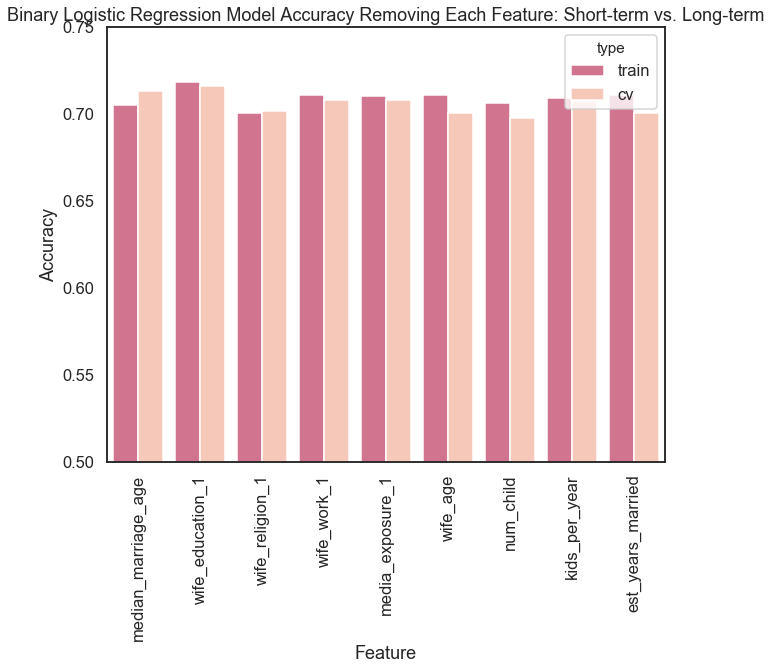

In [46]:
# visualize
ax = visualize_errors(accuracy_train, accuracy_cv_train)
plt.ylim(0.5, 0.75)
ax.set(title = 'Binary Logistic Regression Model Accuracy Removing Each Feature: Short-term vs. Long-term')

#### iv. Random Forests

In [48]:
# to track accuracy for features
accuracy_train_rf = {}
accuracy_cv_rf = {}
n_trees = range(5, 30, 5)

# cross validate for n trees
for i in n_trees:
    
    # fit model
    random_forest = ensemble.RandomForestClassifier(n_estimators = i)
    random_forest.fit(X = X_train_use, y = Y_train_use)
    
    # obtain accuracy
    accuracy_train_rf[i] = random_forest.score(X = X_train_use, y = Y_train_use)
    accuracy_cv_rf[i] = cross_val_score(random_forest, X_train_use, Y_train_use, cv = 5).mean()

{5: 0.5767959482873517,
 10: 0.5800079968012796,
 15: 0.583353325336532,
 20: 0.5784486205517794,
 25: 0.5604558176729307}

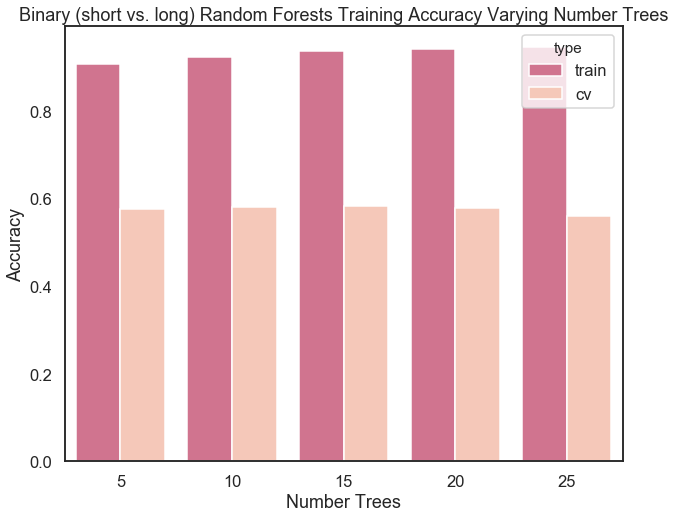

In [49]:
# prepare train df for plotting
accuracy_train_df = pd.DataFrame(accuracy_train_rf.items(), columns = ['n_tree','accuracy'])
accuracy_train_df['type'] = 'train'
accuracy_train_df

# prepare cv df for plotting
accuracy_cv_df = pd.DataFrame(accuracy_cv_rf.items(), columns = ['n_tree','accuracy'])
accuracy_cv_df['type'] = 'cv'

# combine datasets
accuracy_df = pd.concat([accuracy_train_df, accuracy_cv_df])

# generate plot
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'n_tree', y = 'accuracy', hue = 'type', data = accuracy_df,
                palette=['#DF6589', '#FFC3AF'])
ax.set(xlabel='Number Trees',
       ylabel='Accuracy',
       title = 'Binary (short vs. long) Random Forests Training Accuracy Varying Number Trees');

In [50]:
# fit model
binary_use_random_forest = ensemble.RandomForestClassifier(n_estimators = 15)
binary_use_random_forest.fit(X = X_train_use, y = Y_train_use)

# obtain accuracies
train_accuracy_rf_use = binary_use_random_forest.score(X = X_train_use, y = Y_train_use)
test_accuracy_rf_use  = binary_use_random_forest.score(X = X_test_use, y = Y_test_use)

# print
[train_accuracy_rf_use, test_accuracy_rf_use]

[0.9411764705882353, 0.6206896551724138]

## 4. Assessing Precision and Recall